In [2]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras

from keras.datasets import mnist
from keras.models import Model
from keras import optimizers
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from matplotlib import cm, transforms

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

from skai.runner import TextRunner, Adam_lambda

def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

Using TensorFlow backend.


# Data Loading

In [3]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [4]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [5]:
yall
Xall.shape

(550,)

In [6]:
itos = trunner.alldata.tvectorizer.itos
stoi = trunner.alldata.tvectorizer.stoi

In [7]:
total_vocabs = len(itos) 
print(total_vocabs)

# Unknown vocabs are set to <UNK>.
encoder = stoi
decoder = itos

print('We have %d vocabs.' % total_vocabs)

5036
We have 5036 vocabs.


In [8]:
maxlen = max([x.shape[0] for x in Xall])
Xall_const_size = np.ones((Xall.shape[0], maxlen))
for i, x in enumerate(Xall):
    curlen = x.shape[0]
    Xall_const_size[i][: curlen] = x
print(Xall_const_size.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xall_const_size, yall, test_size=0.2, random_state=42)
print(Xtrain.shape)
print(Xtest.shape)

(550, 1325)
(440, 1325)
(110, 1325)


# Pretraining Embed Layer

In [218]:
def train_embed(model,  batch_size=64, epochs=20):
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(Xtrain, ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xtest, ytest),
                        shuffle=True
                       )

In [219]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["embed"] = Embedding(total_vocabs, 300, input_length=1325)(net["in"])
    net["conv1"] = keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(net["embed"])
    net["conv2"] = keras.layers.Conv1D(filters=512, kernel_size=4, activation='relu', padding='same')(net["embed"])
    net["conv3"] = keras.layers.Conv1D(filters=512, kernel_size=5, activation='relu', padding='same')(net["embed"])
    net["pool1"] = keras.layers.MaxPooling1D()(net["conv1"])
    net["pool2"] = keras.layers.MaxPooling1D()(net["conv2"])
    net["pool3"] = keras.layers.MaxPooling1D()(net["conv3"])
    net["cat"] = keras.layers.Concatenate()([net["pool1"], net["pool2"], net["pool3"]])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["cat"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1325), 5)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [220]:
train_embed(model_with_softmax, batch_size=32, epochs=10)

Train on 440 samples, validate on 110 samples
Epoch 1/10
440/440 [==============================] - 2s 5ms/step - loss: 2.9956 - acc: 0.1955 - val_loss: 1.6285 - val_acc: 0.2545
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 1.5462 - acc: 0.5750 - val_loss: 1.6766 - val_acc: 0.3000
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 1.3876 - acc: 0.6773 - val_loss: 1.7662 - val_acc: 0.2909
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.8560 - acc: 0.7409 - val_loss: 1.8560 - val_acc: 0.4091
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.2942 - acc: 0.9114 - val_loss: 2.2871 - val_acc: 0.4000
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.0551 - acc: 0.9955 - val_loss: 2.5678 - val_acc: 0.4000
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.0490 - acc: 0.9977 - val_loss: 2.9584 - val_acc: 0.3636
Epoch 8/10
440/440 [==========

In [175]:
embedding = model_with_softmax.layers[1].get_weights()[0]
embedding.shape

(5036, 300)

In [9]:
# np.save('data/5s_embedding.npy', embedding)
embedding = np.load('data/5s_embedding.npy')

In [10]:
print(embedding)
embedding.shape

[[ 0.02382 -0.01473 -0.01735 ...  0.03525 -0.04912  0.0298 ]
 [-0.03624  0.00625 -0.03284 ...  0.02526 -0.02534 -0.02377]
 [-0.02137 -0.04553 -0.02568 ...  0.01285 -0.01394 -0.01436]
 ...
 [ 0.06179 -0.05283  0.04909 ...  0.0682  -0.00387 -0.02762]
 [ 0.0361  -0.02298  0.0349  ...  0.0554  -0.02907  0.02321]
 [-0.00957 -0.03425 -0.02323 ... -0.04789  0.04046 -0.03878]]


(5036, 300)

# Data Preprocessing

In [11]:
Xtrain_emb = np.zeros((440, 1325, 300))
Xtest_emb = np.zeros((110, 1325, 300))

for i, x in enumerate(Xtrain):
    x_ = np.array([embedding[int(p)] for p in x])
    Xtrain_emb[i, :, :] = x_
Xtrain_emb = Xtrain_emb[:, np.newaxis, :, :]

print(Xtrain_emb.shape)

for i, x in enumerate(Xtest):
    x_ = np.array([embedding[int(p)] for p in x])
    Xtest_emb[i, :, :] = x_
Xtest_emb = Xtest_emb[:, np.newaxis, :, :]

print(Xtest_emb.shape)

(440, 1, 1325, 300)
(110, 1, 1325, 300)


# Using the INNvestigate model

In [12]:
def train_model(model,  batch_size=64, epochs=20):
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(Xtrain_emb, ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xtest_emb, ytest),
                        shuffle=True
                       )

In [13]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, 1325, 300), 5)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [15]:
train_model(model_with_softmax, batch_size=64, epochs=10)

Train on 440 samples, validate on 110 samples
Epoch 1/10
440/440 [==============================] - 1s 2ms/step - loss: 1.2297 - acc: 0.7068 - val_loss: 1.4238 - val_acc: 0.3818
Epoch 2/10
440/440 [==============================] - 1s 1ms/step - loss: 1.1897 - acc: 0.7114 - val_loss: 1.4002 - val_acc: 0.4455
Epoch 3/10
440/440 [==============================] - 1s 1ms/step - loss: 1.1534 - acc: 0.7409 - val_loss: 1.3841 - val_acc: 0.4636
Epoch 4/10
440/440 [==============================] - 1s 1ms/step - loss: 1.1186 - acc: 0.7568 - val_loss: 1.3709 - val_acc: 0.4909
Epoch 5/10
440/440 [==============================] - 1s 1ms/step - loss: 1.0844 - acc: 0.7795 - val_loss: 1.3578 - val_acc: 0.4818
Epoch 6/10
440/440 [==============================] - 1s 1ms/step - loss: 1.0486 - acc: 0.7773 - val_loss: 1.3411 - val_acc: 0.4727
Epoch 7/10
440/440 [==============================] - 1s 1ms/step - loss: 1.0158 - acc: 0.7750 - val_loss: 1.3290 - val_acc: 0.4727
Epoch 8/10
440/440 [==========

In [16]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [17]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for available methods.
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']

In [18]:
# build an analyzer for each method
analyzers = []

for method in methods:
    analyzer = innvestigate.create_analyzer(method, model_without_softmax)
    analyzer.fit(Xtrain_emb, batch_size=64, verbose=1)
    analyzers.append(analyzer)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/innvestigate/analyzer/base.py:136: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
7/7 [==============================] - 0s 70ms/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


In [25]:
# specify indices of reviews that we want to investigate
test_sample_indices = [1, 5, 78, 109]

test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, 1325])

for i, ridx in enumerate(test_sample_indices):

    x, y = Xtest_emb[ridx], ytest[ridx]

    t_start = time.time()
    x = x.reshape((1, 1, 1325, 300))

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    print(y_hat)
    print(y)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

#         analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

0
[1 0 0 0 0]
Review 1 (0.0146s)
3
[0 0 0 0 1]
Review 5 (0.0132s)
2
[0 0 1 0 0]
Review 78 (0.0121s)
1
[0 1 0 0 0]
Review 109 (0.0122s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review. 

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [20]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


### An Example of  The Visualization
Let assume we have this review `I really love this movie but not in the beginning`. It is predicted as `positive`, and the relevance scores are distributed as follows: 

```
        I 0.20
    really 0.20
      love 0.50
      this 0.10
     movie 0.10
       but 0.10
       not -0.20
        in 0.05
       the 0.05
 beginning 0.08
```

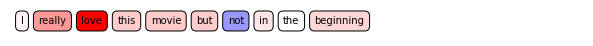

In [21]:
plot_text_heatmap(
    "I really love this movie but not in the beginning".split(' '),
    np.array([0.02, 0.2, 0.5, 0.1, 0.1, 0.1, -0.2, 0.05, 0.00, 0.08])
)

# "love" is shaded with strong red because its relevance score is rather high
# "not" is highlighted in light blue because of its negative score.

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


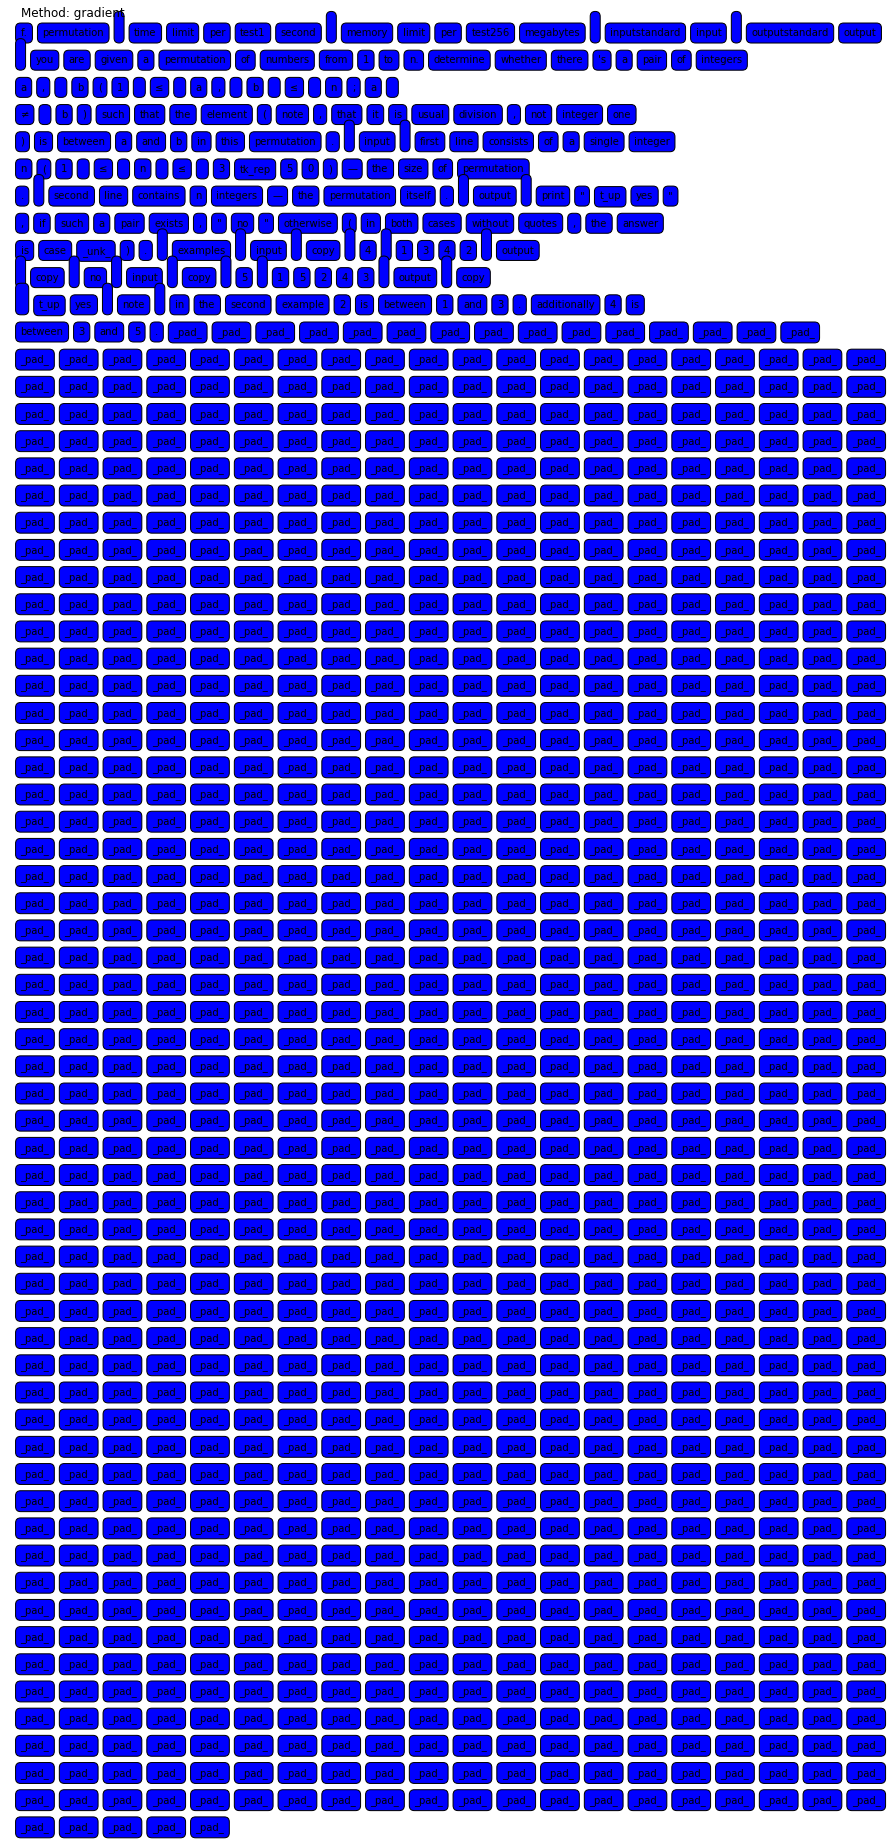

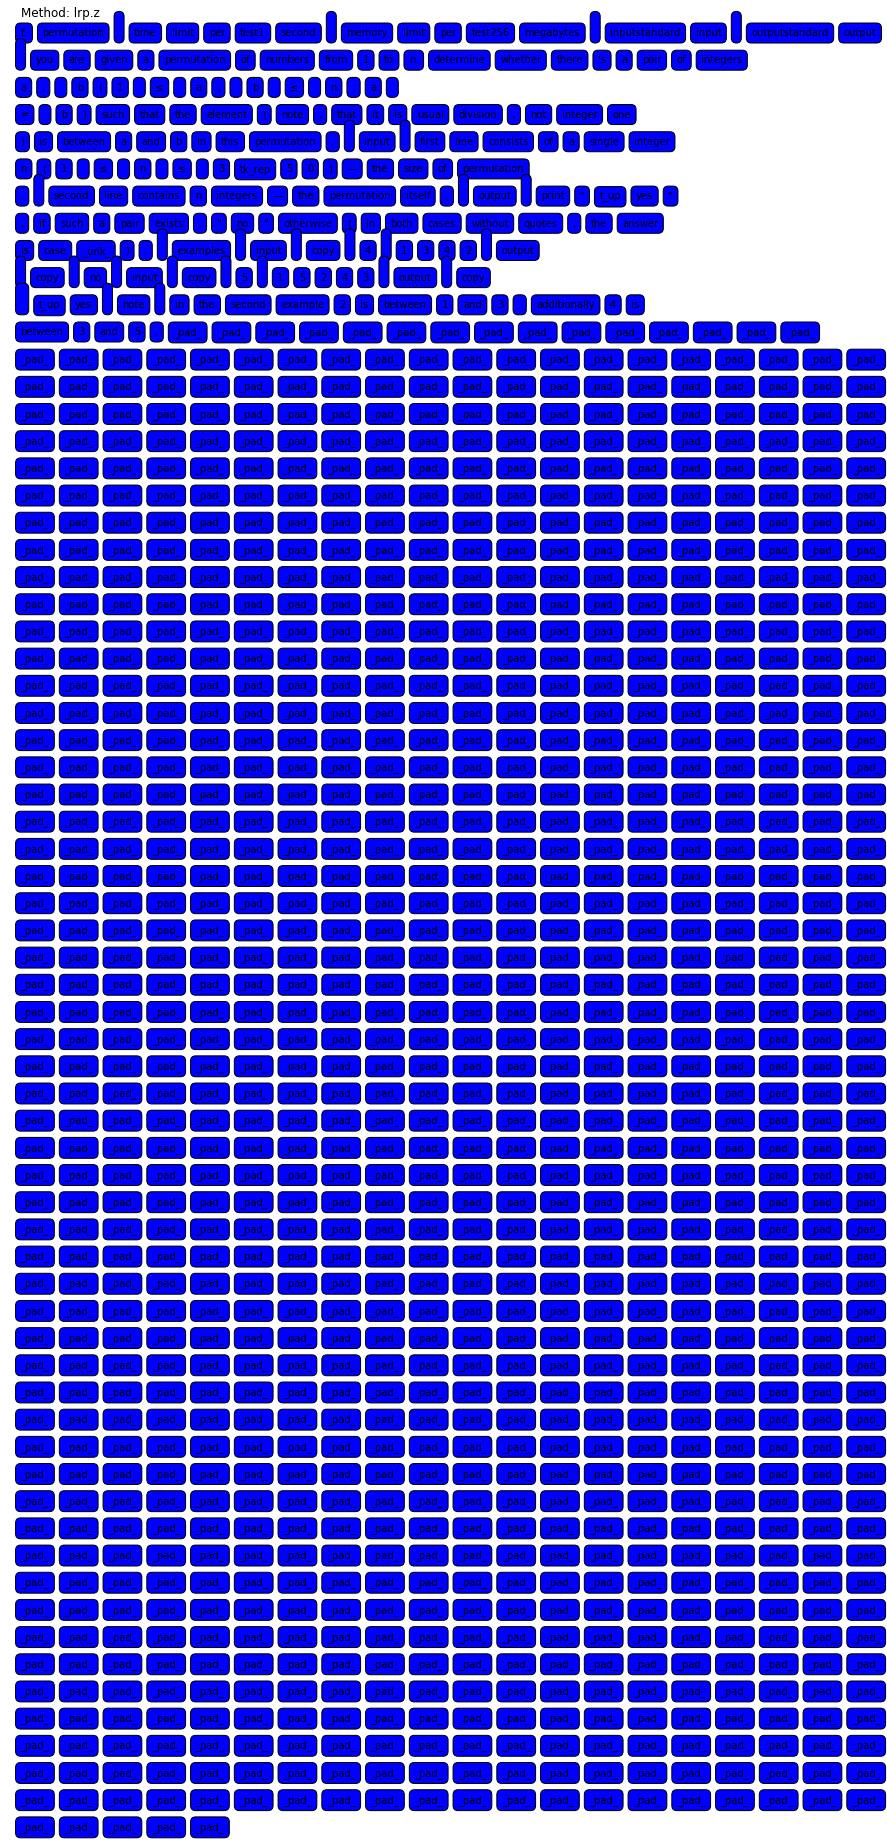

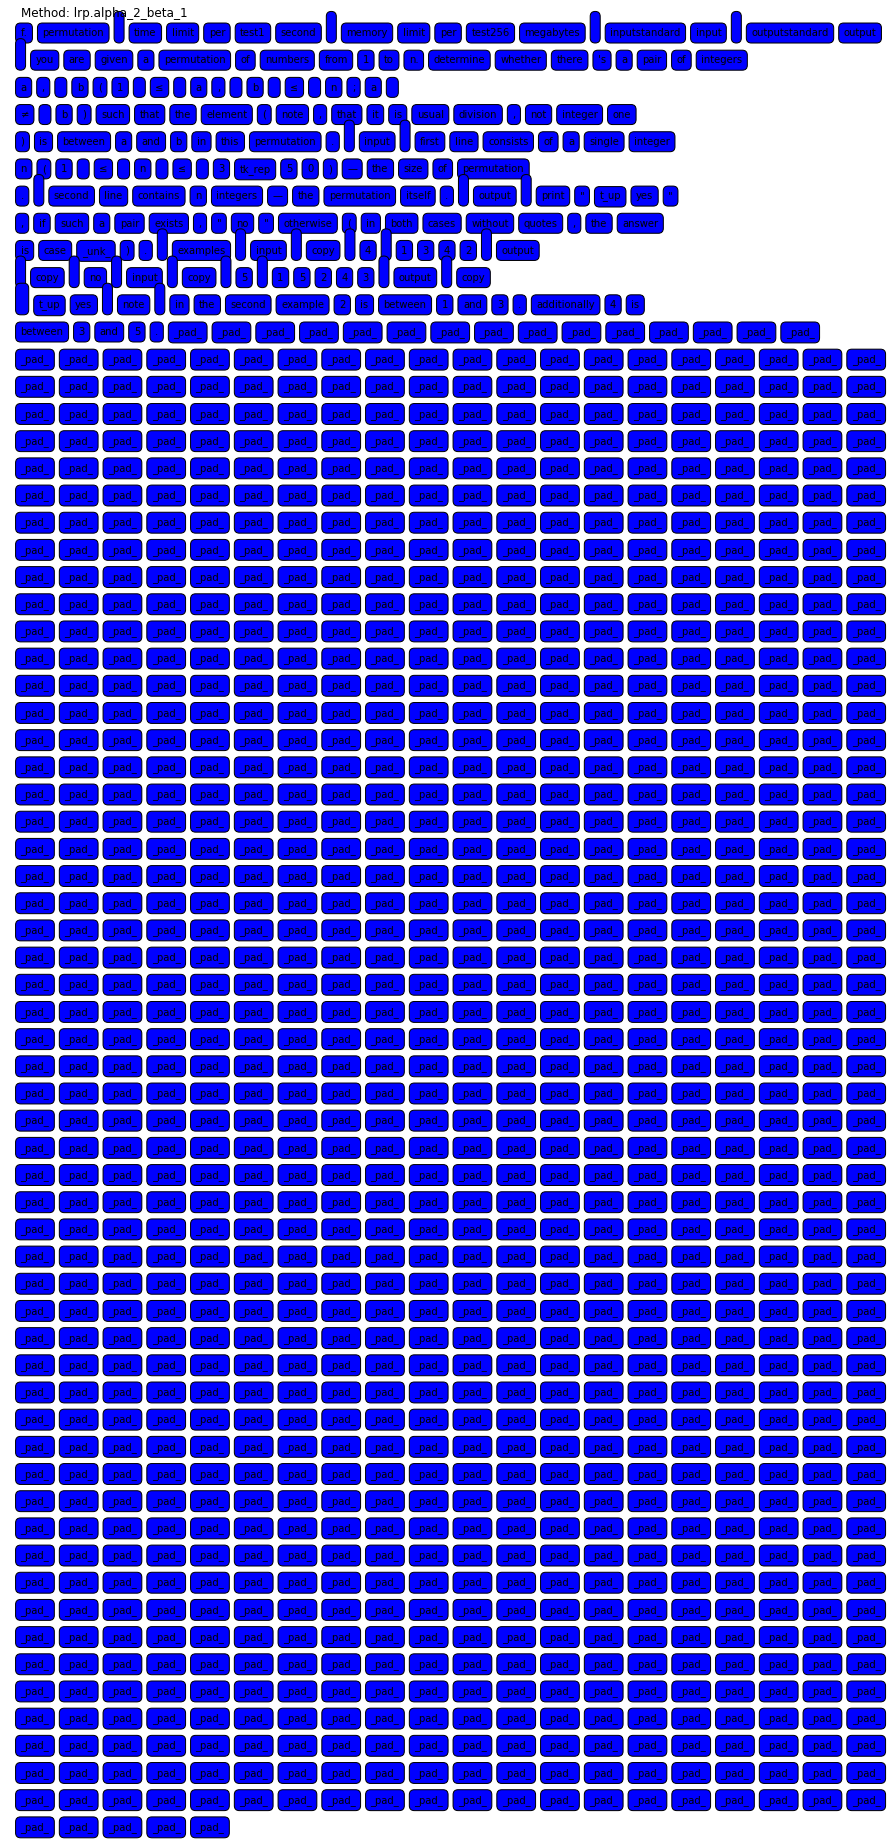

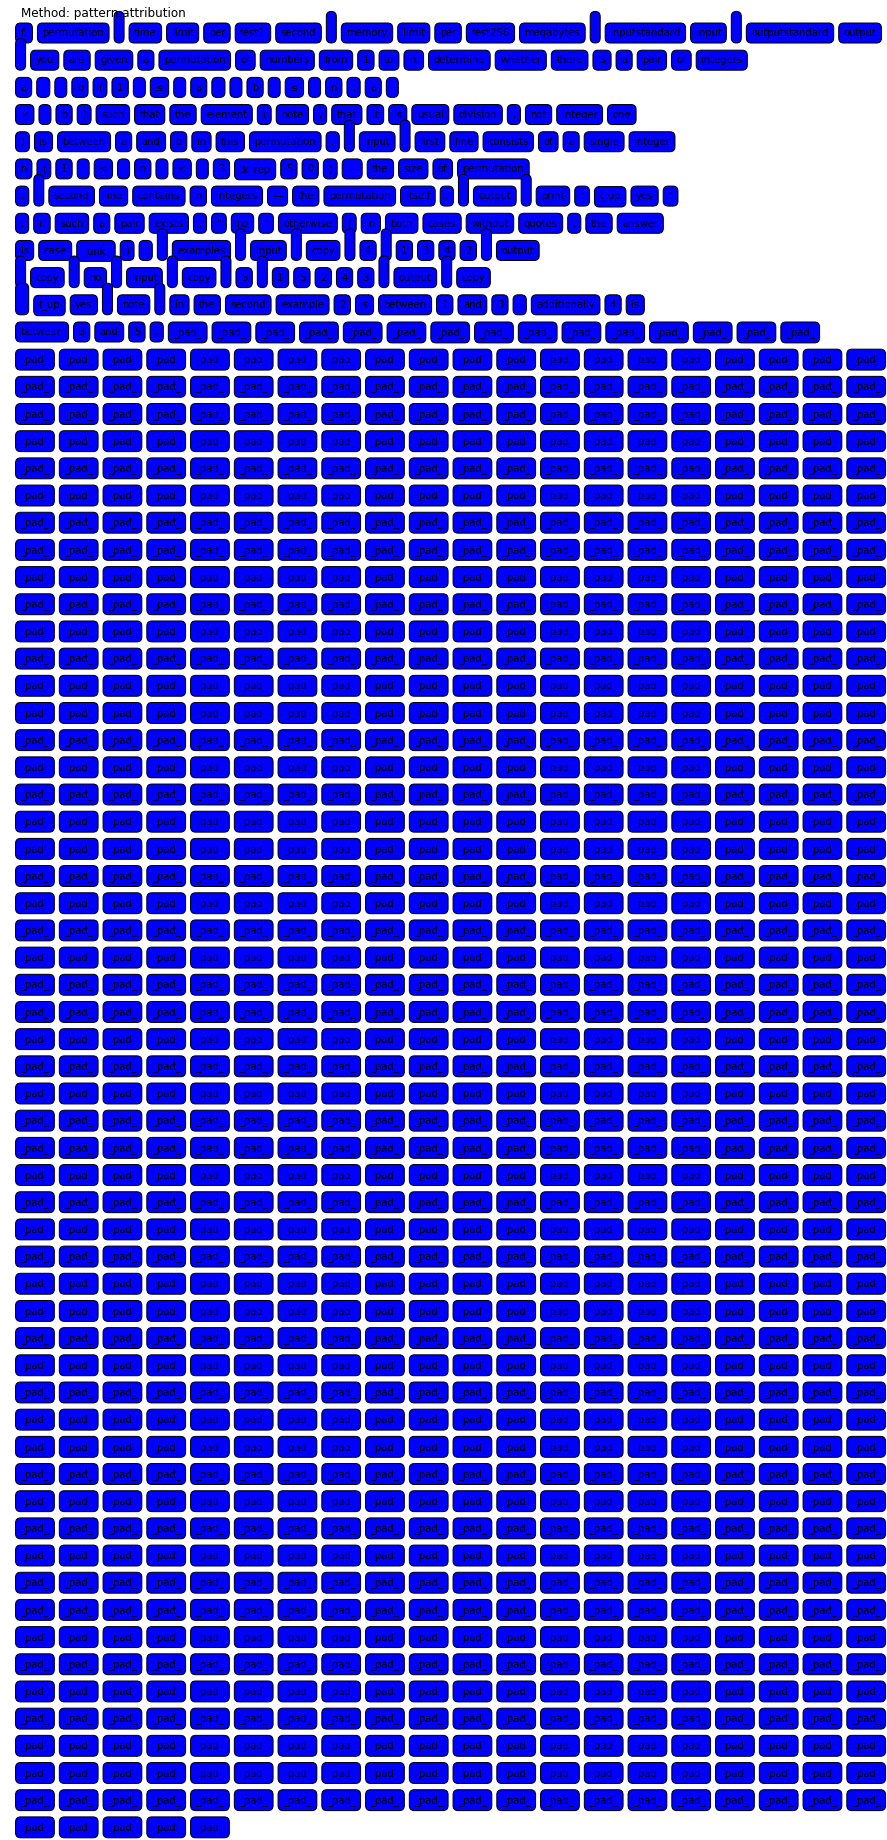

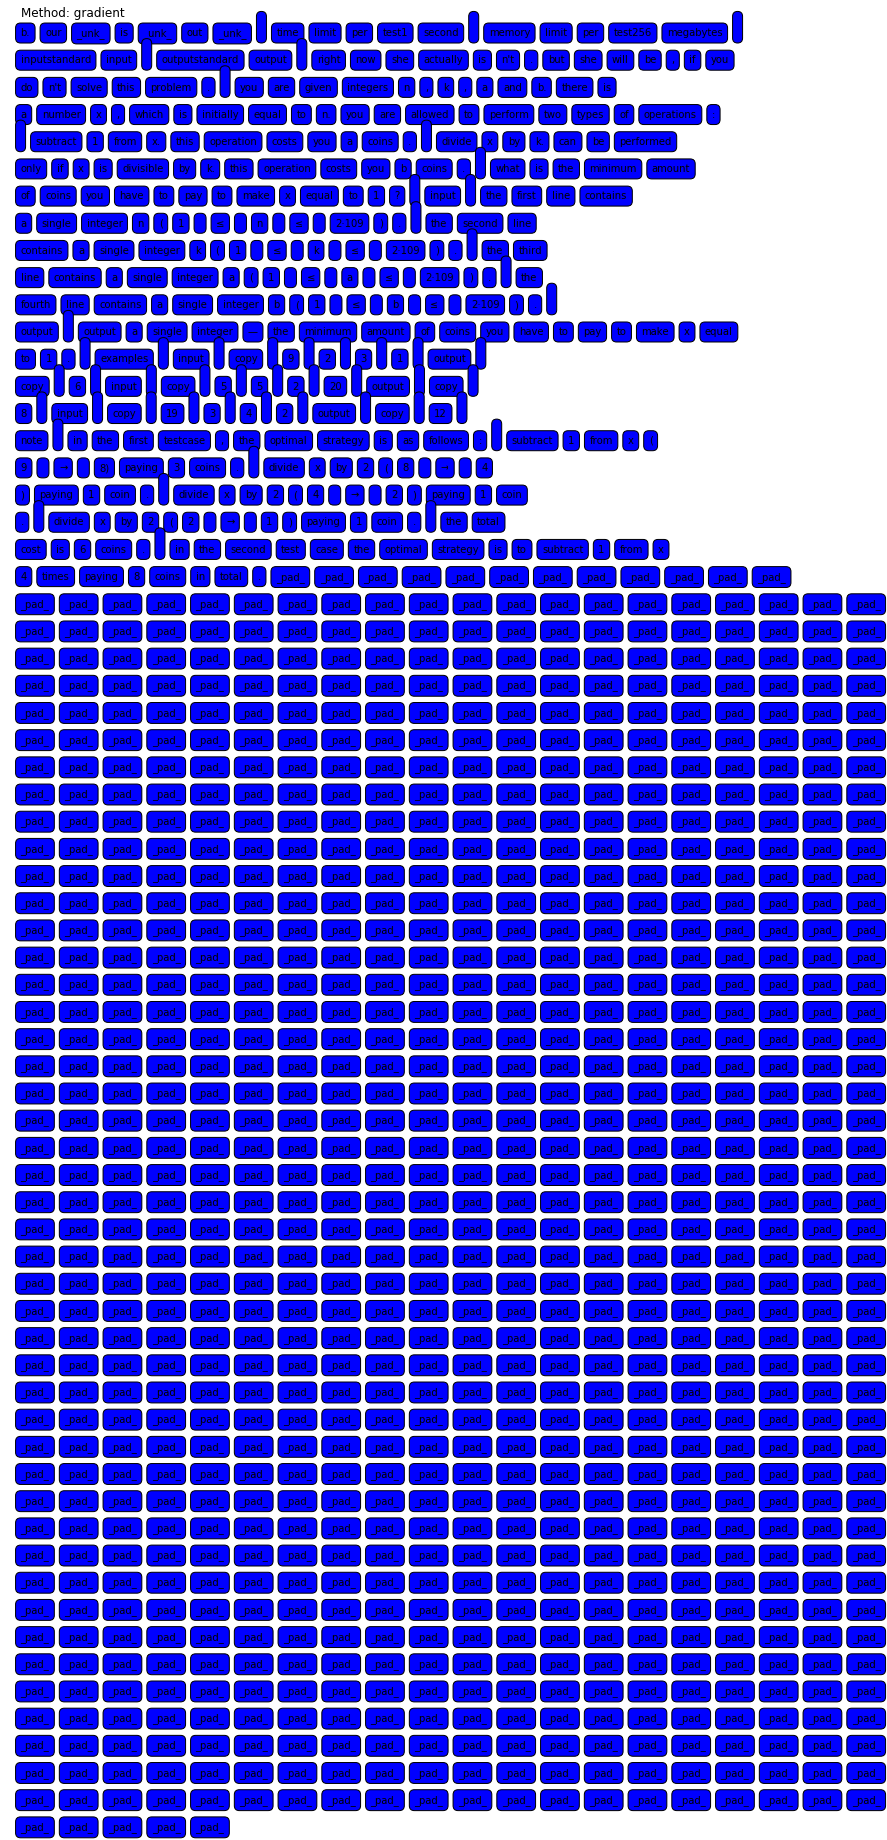

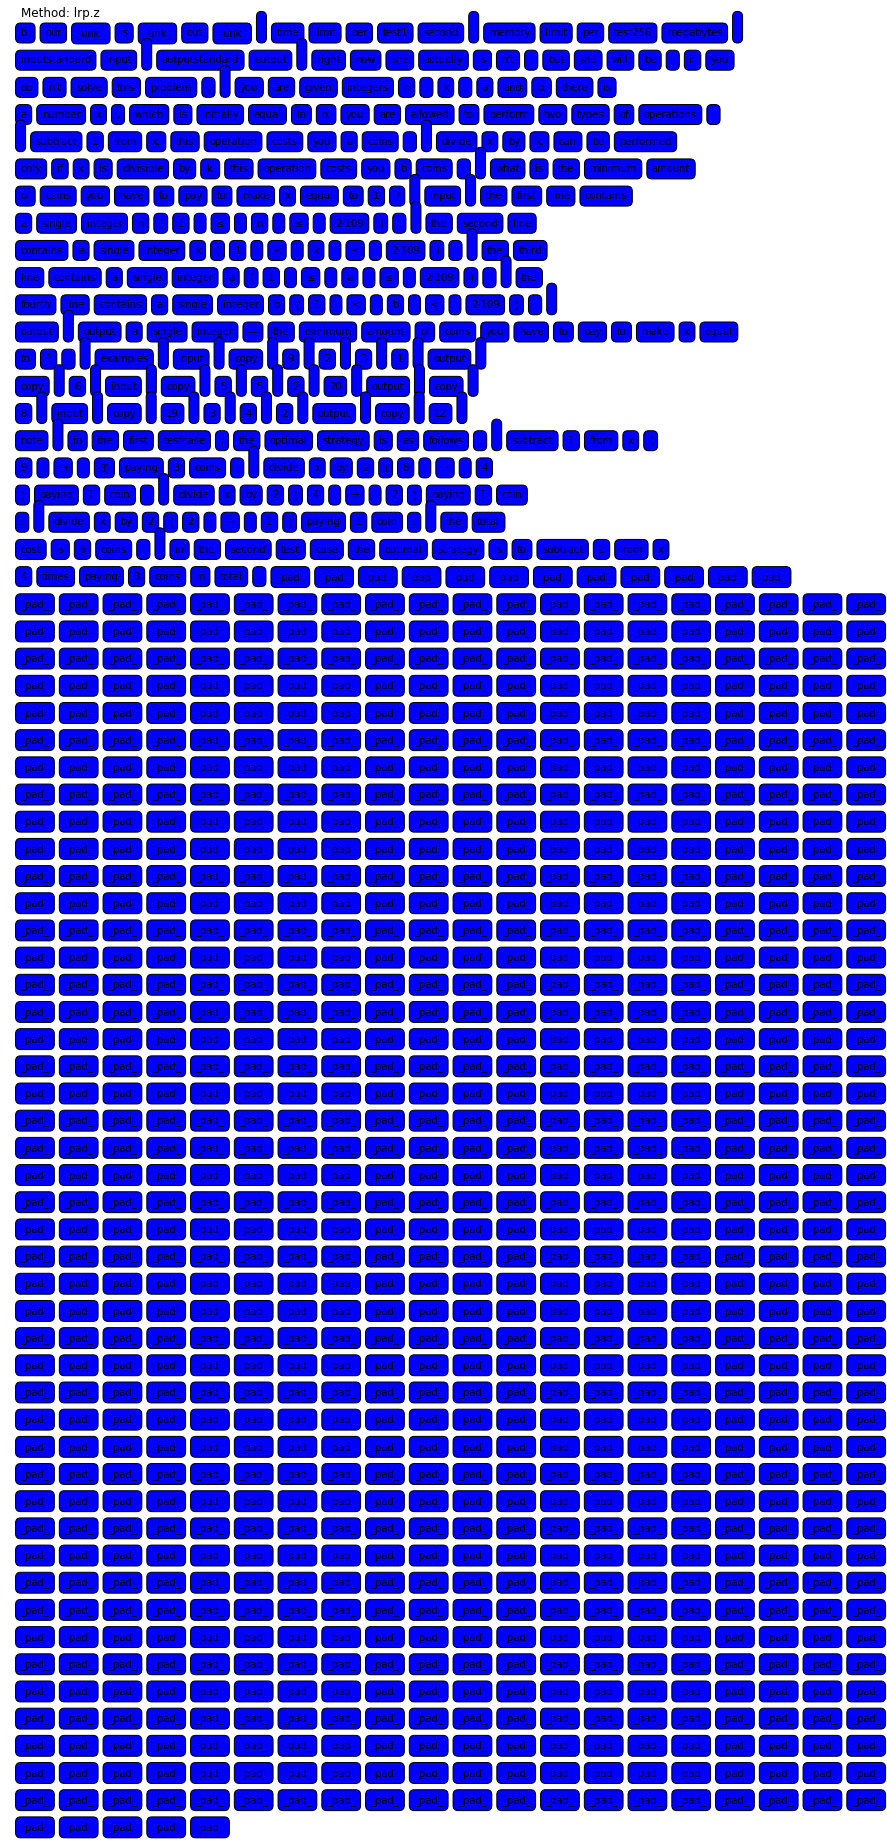

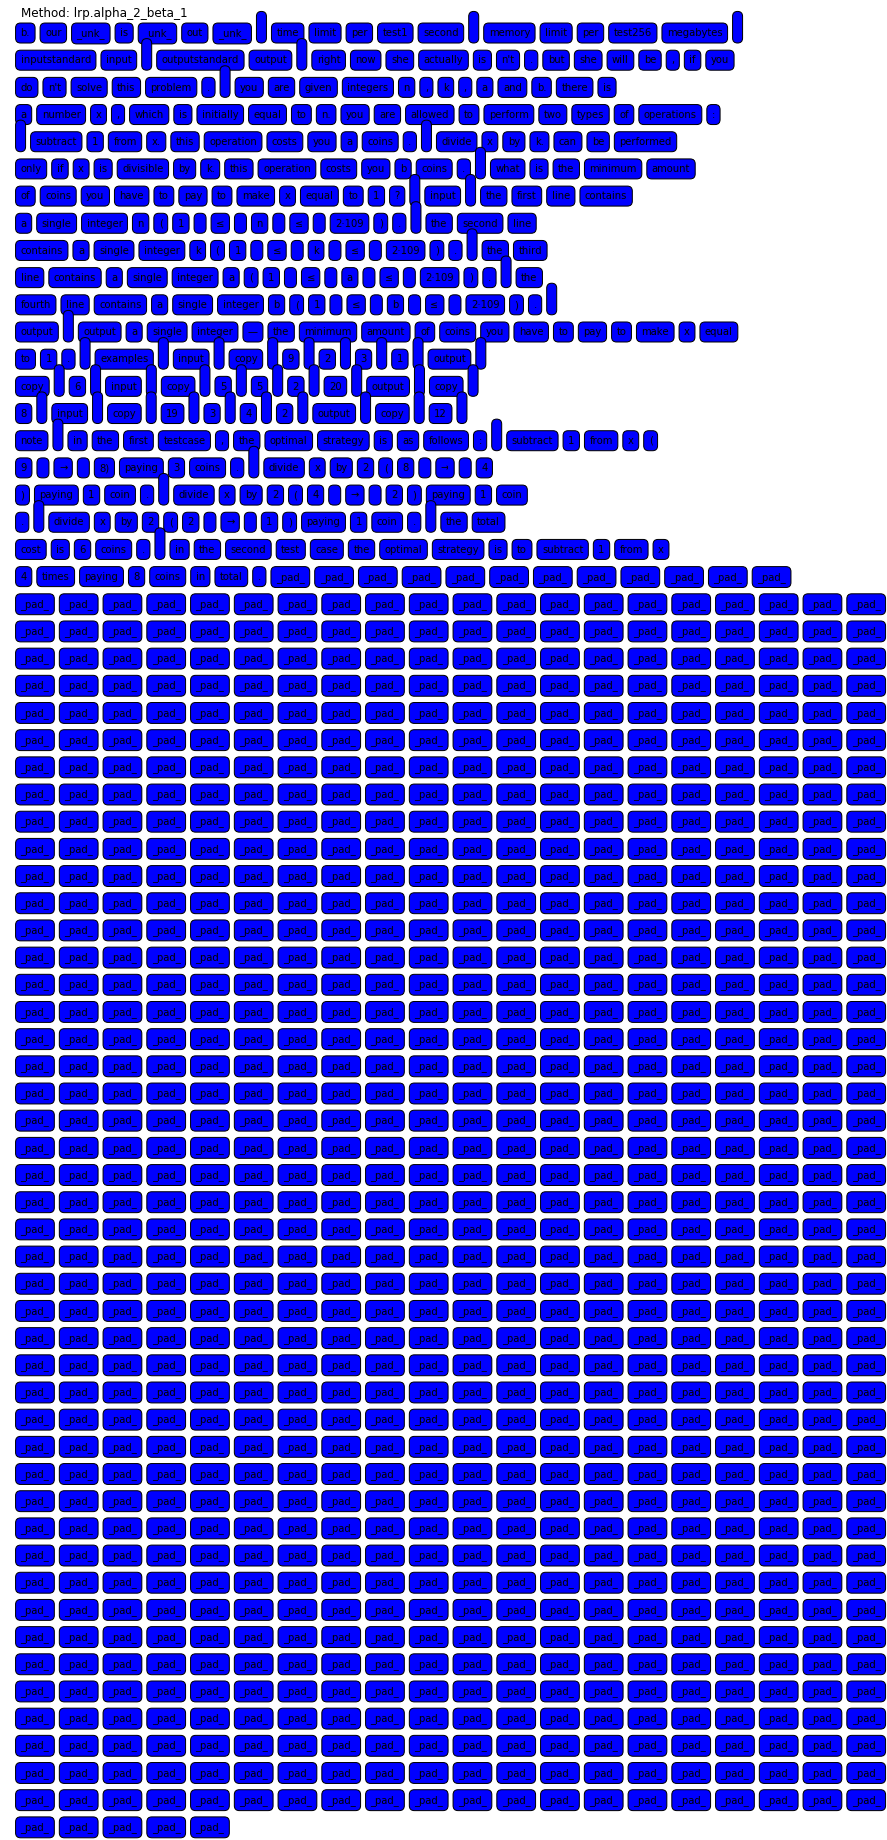

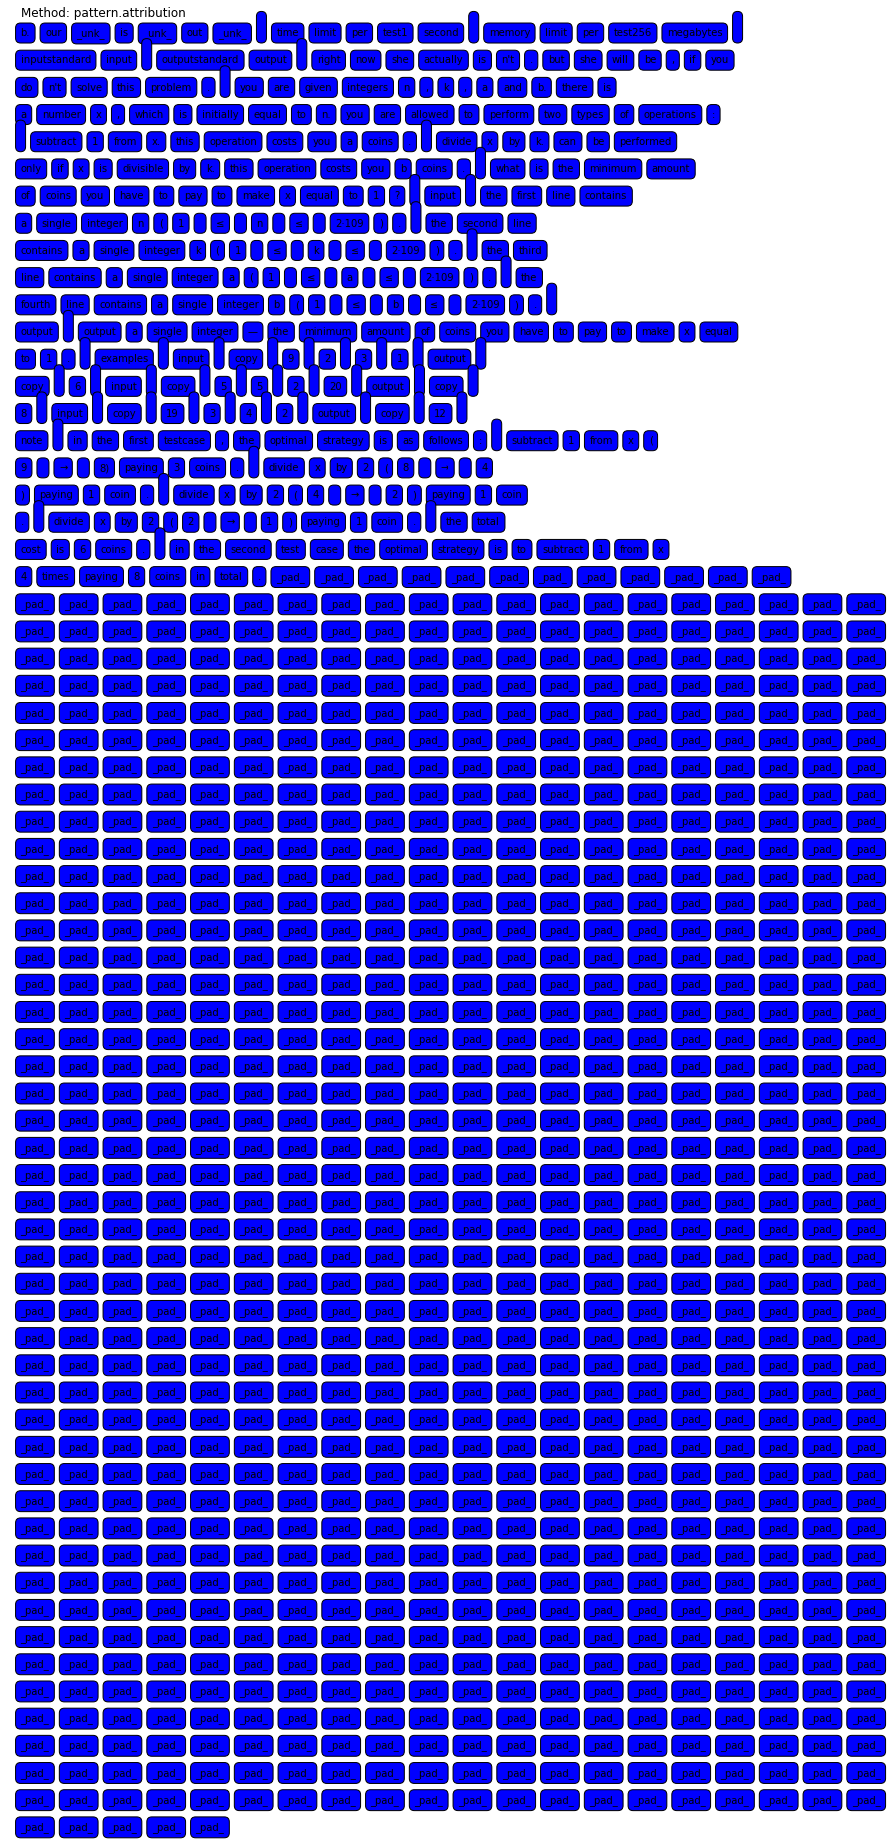

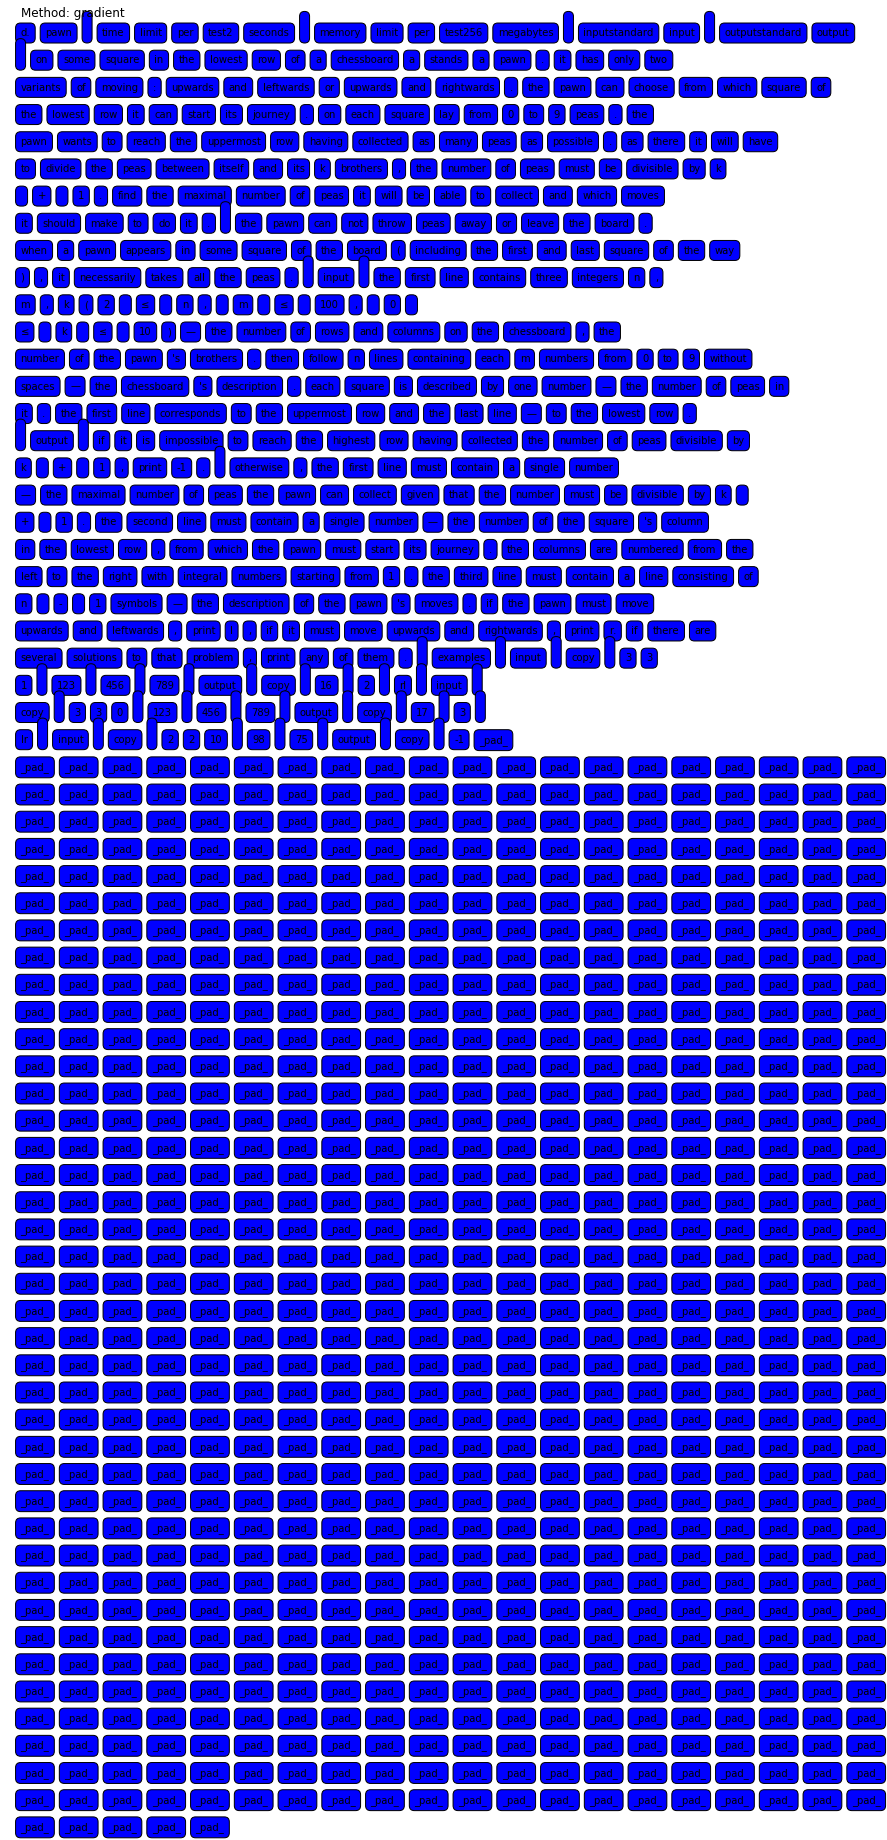

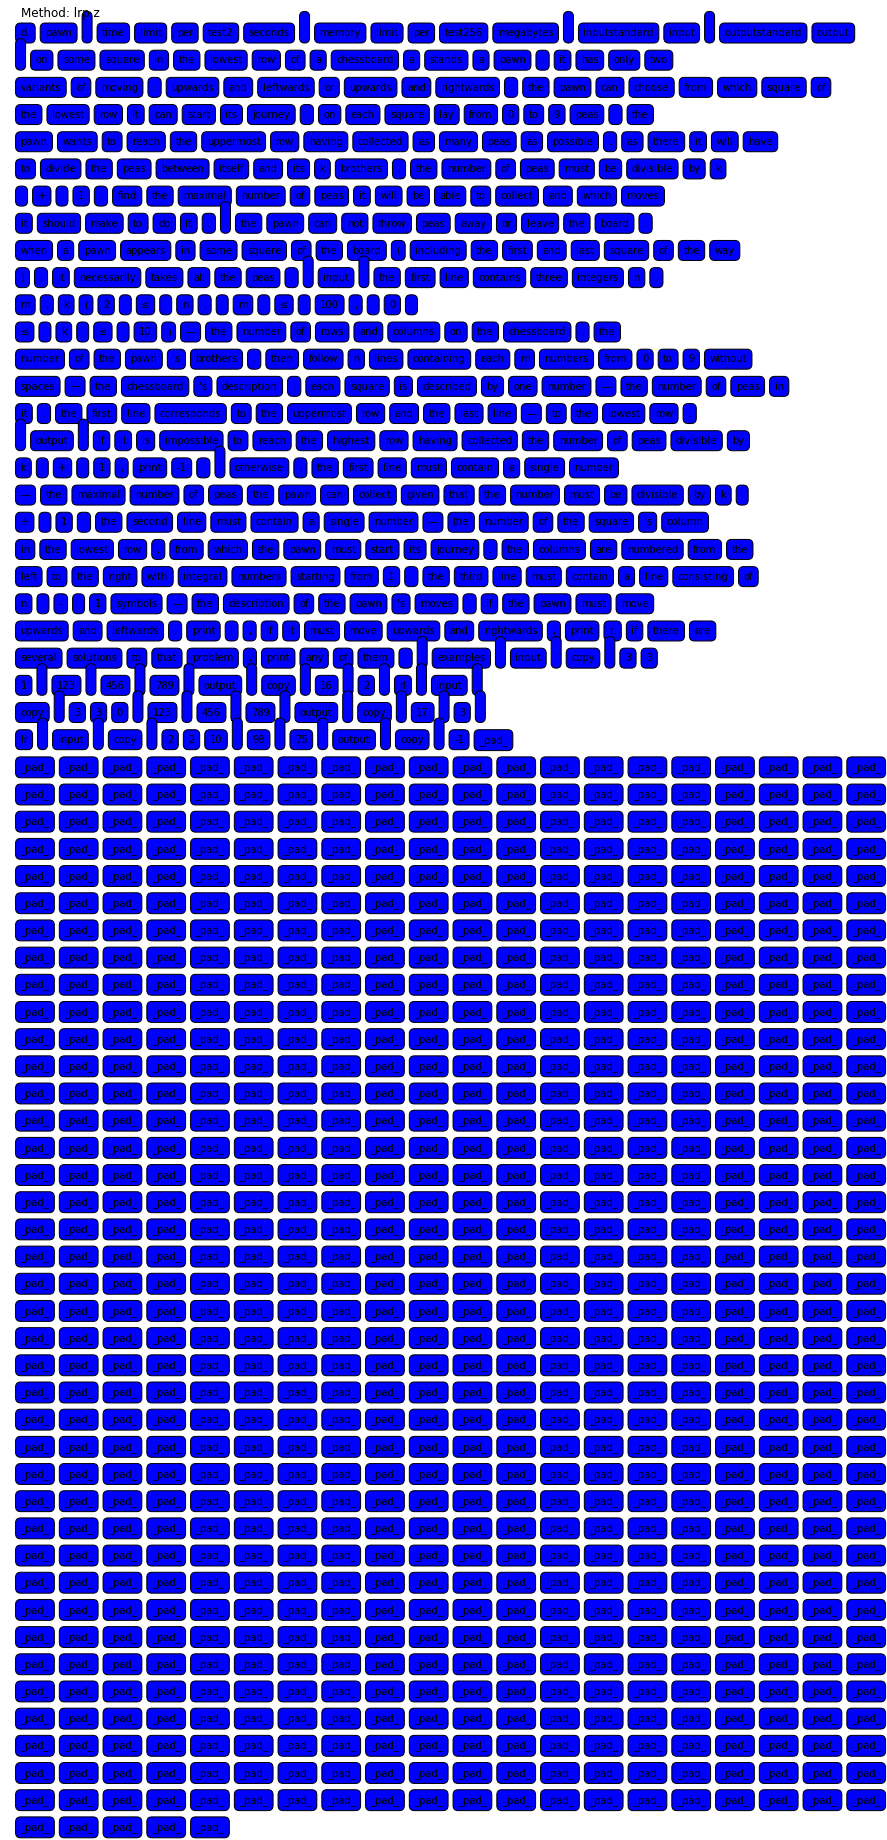

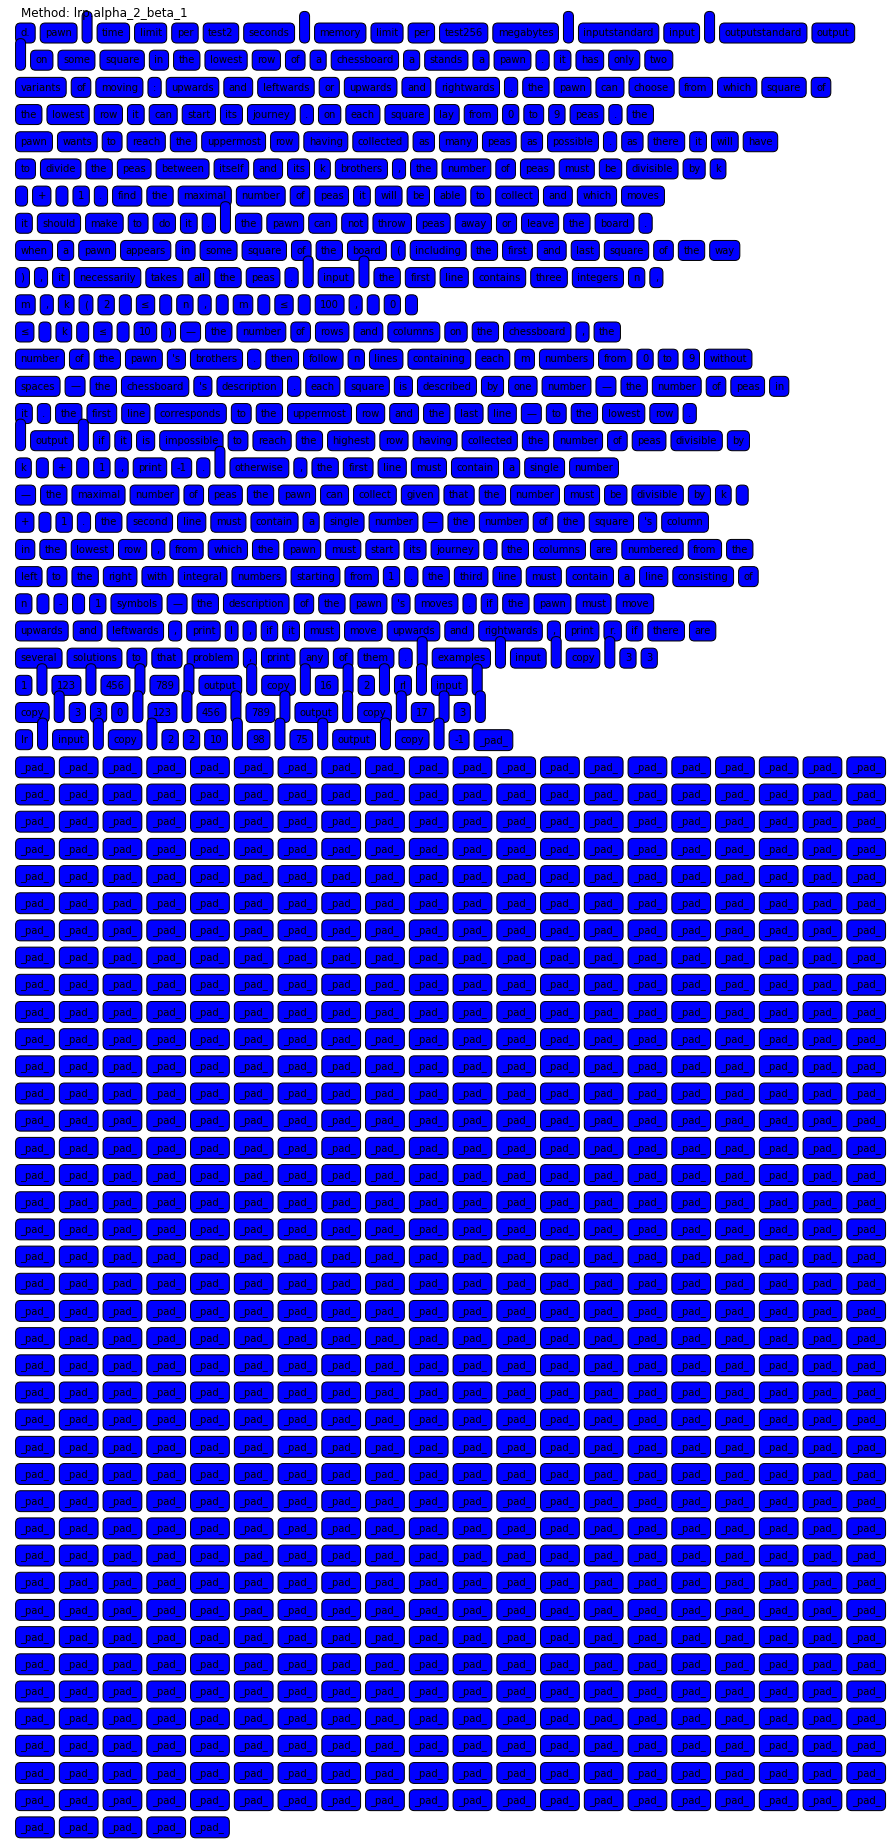

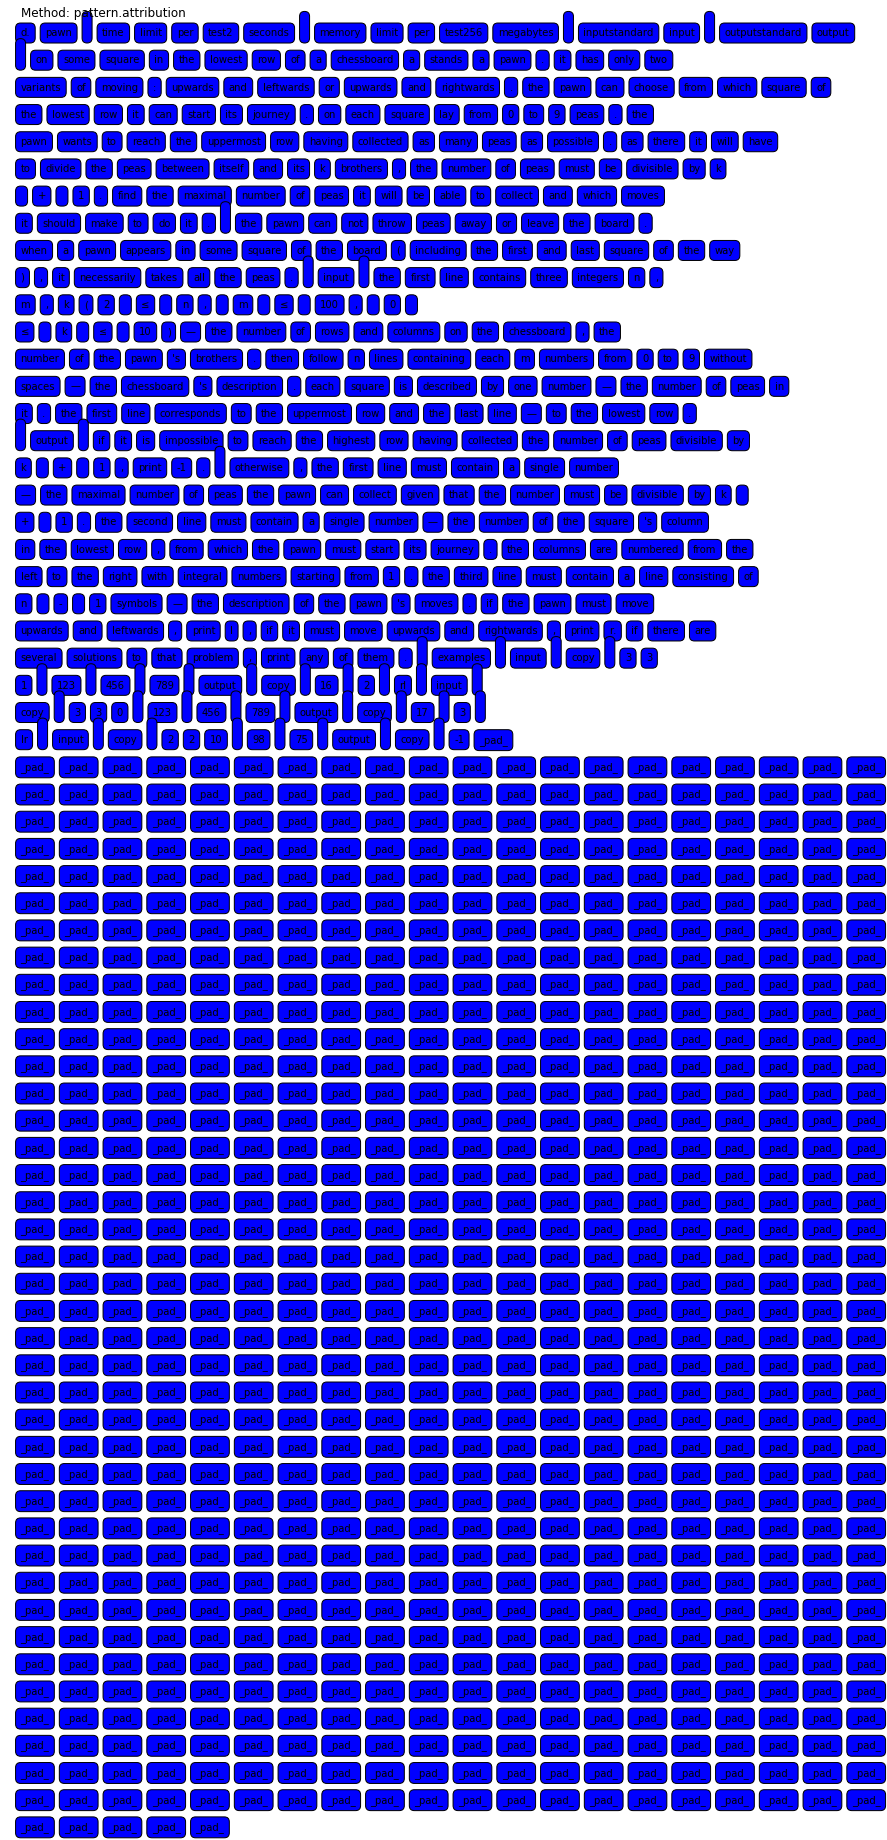

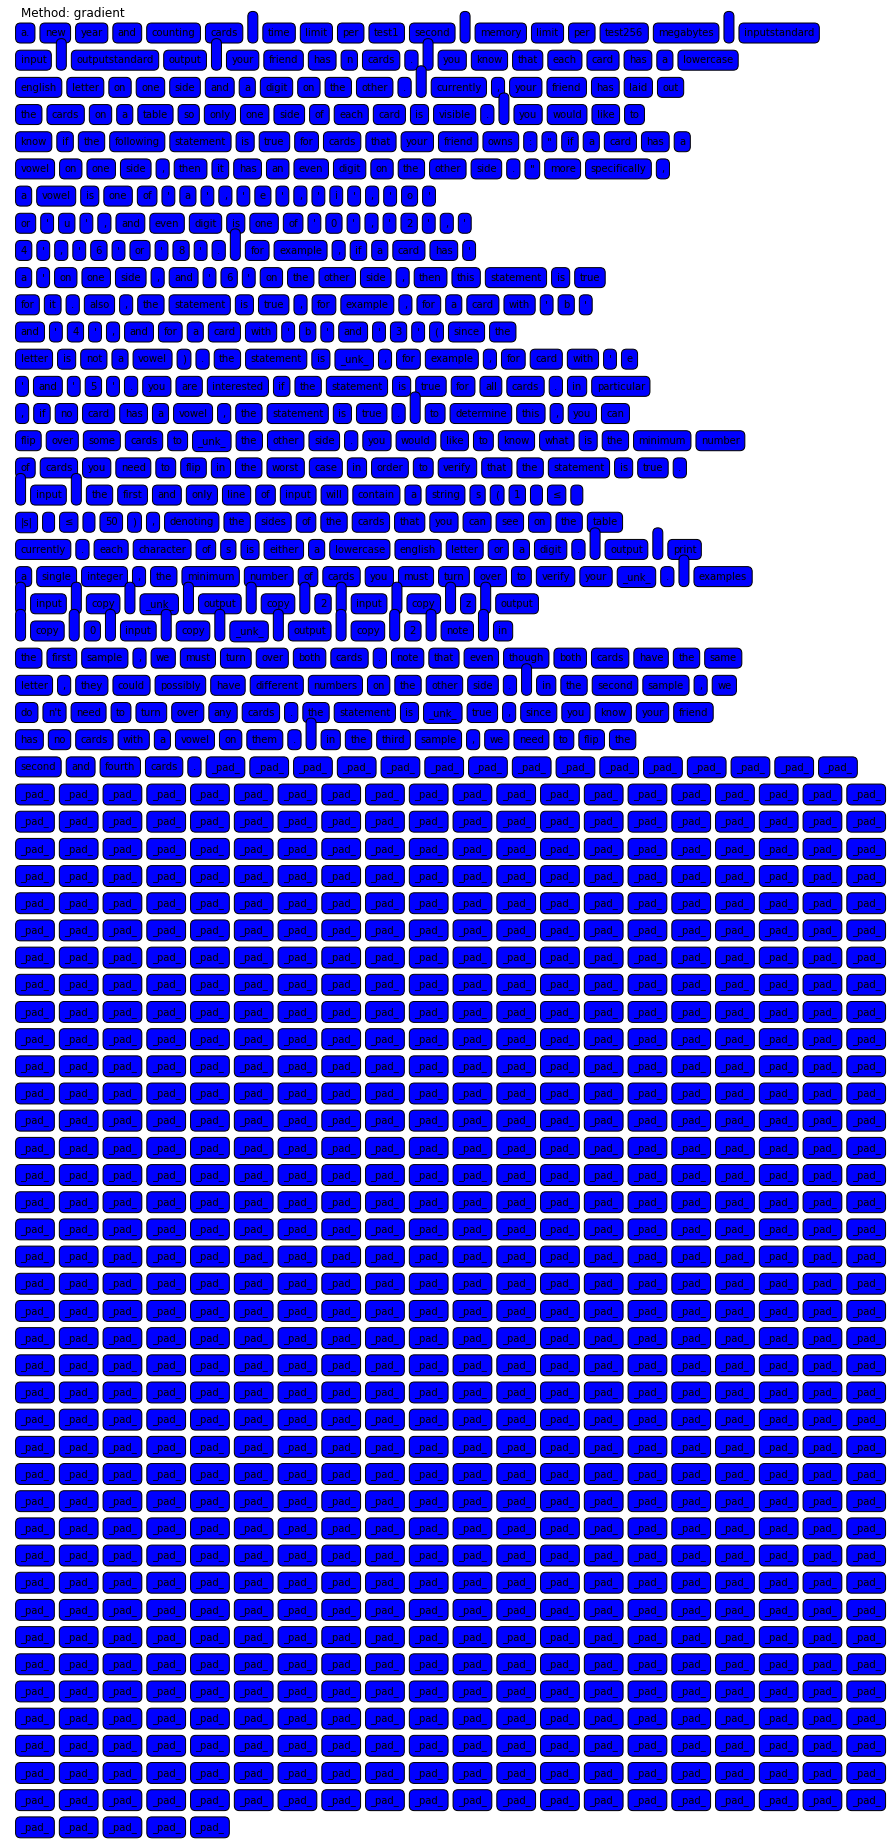

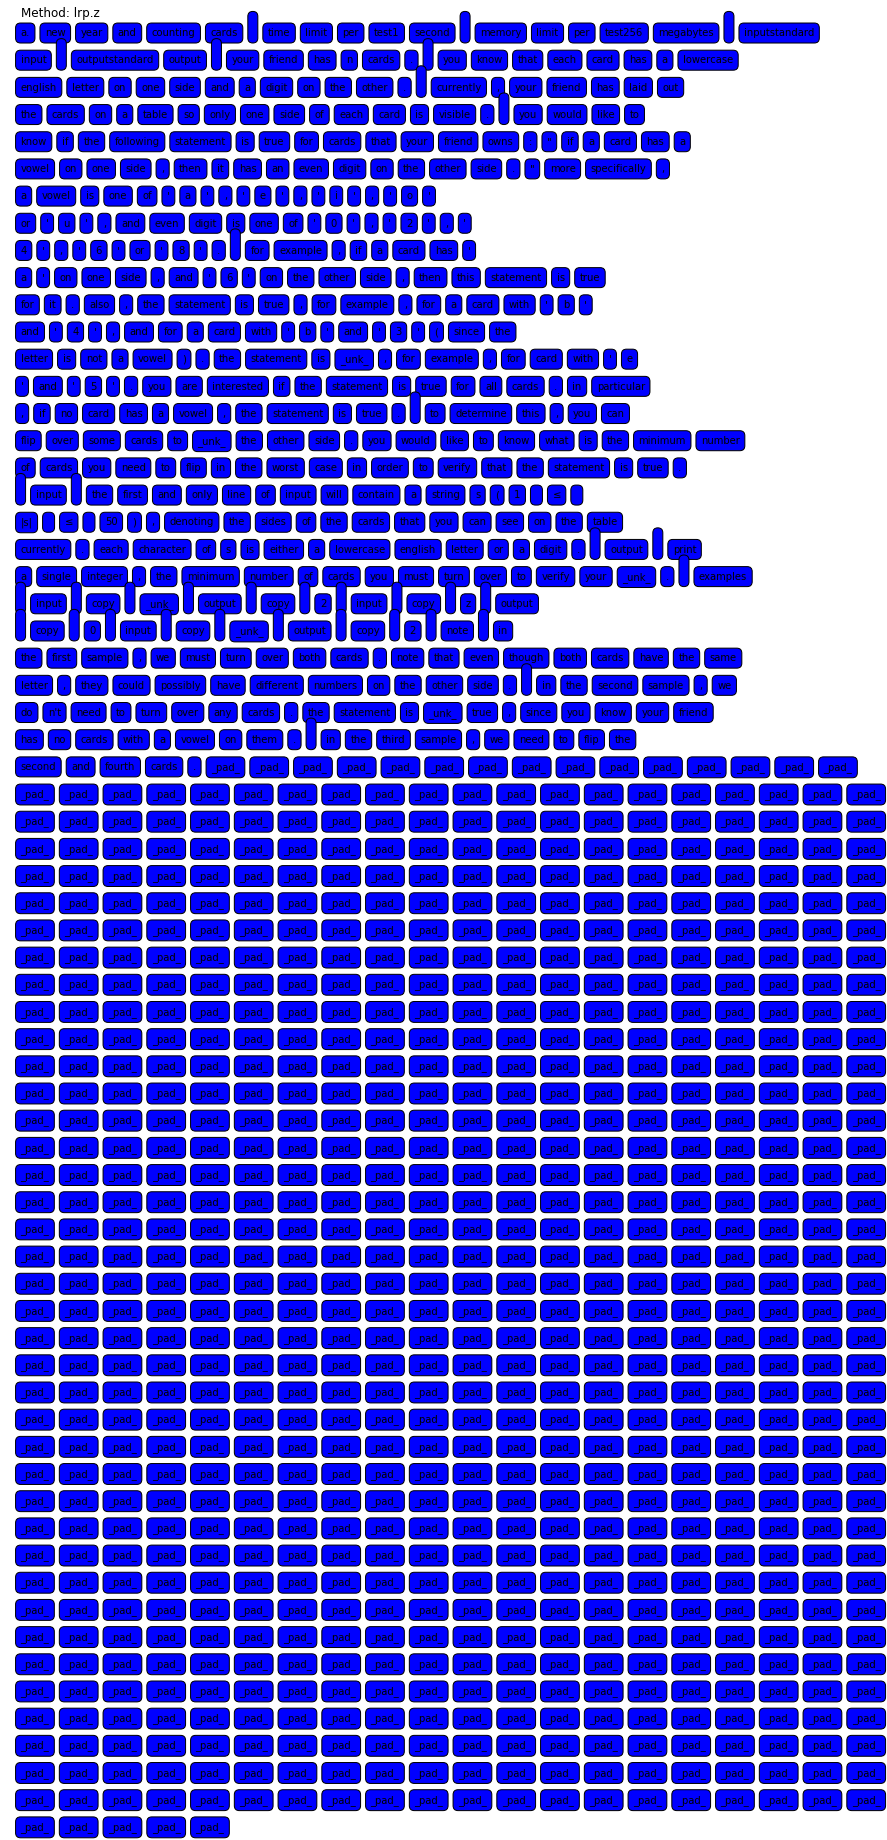

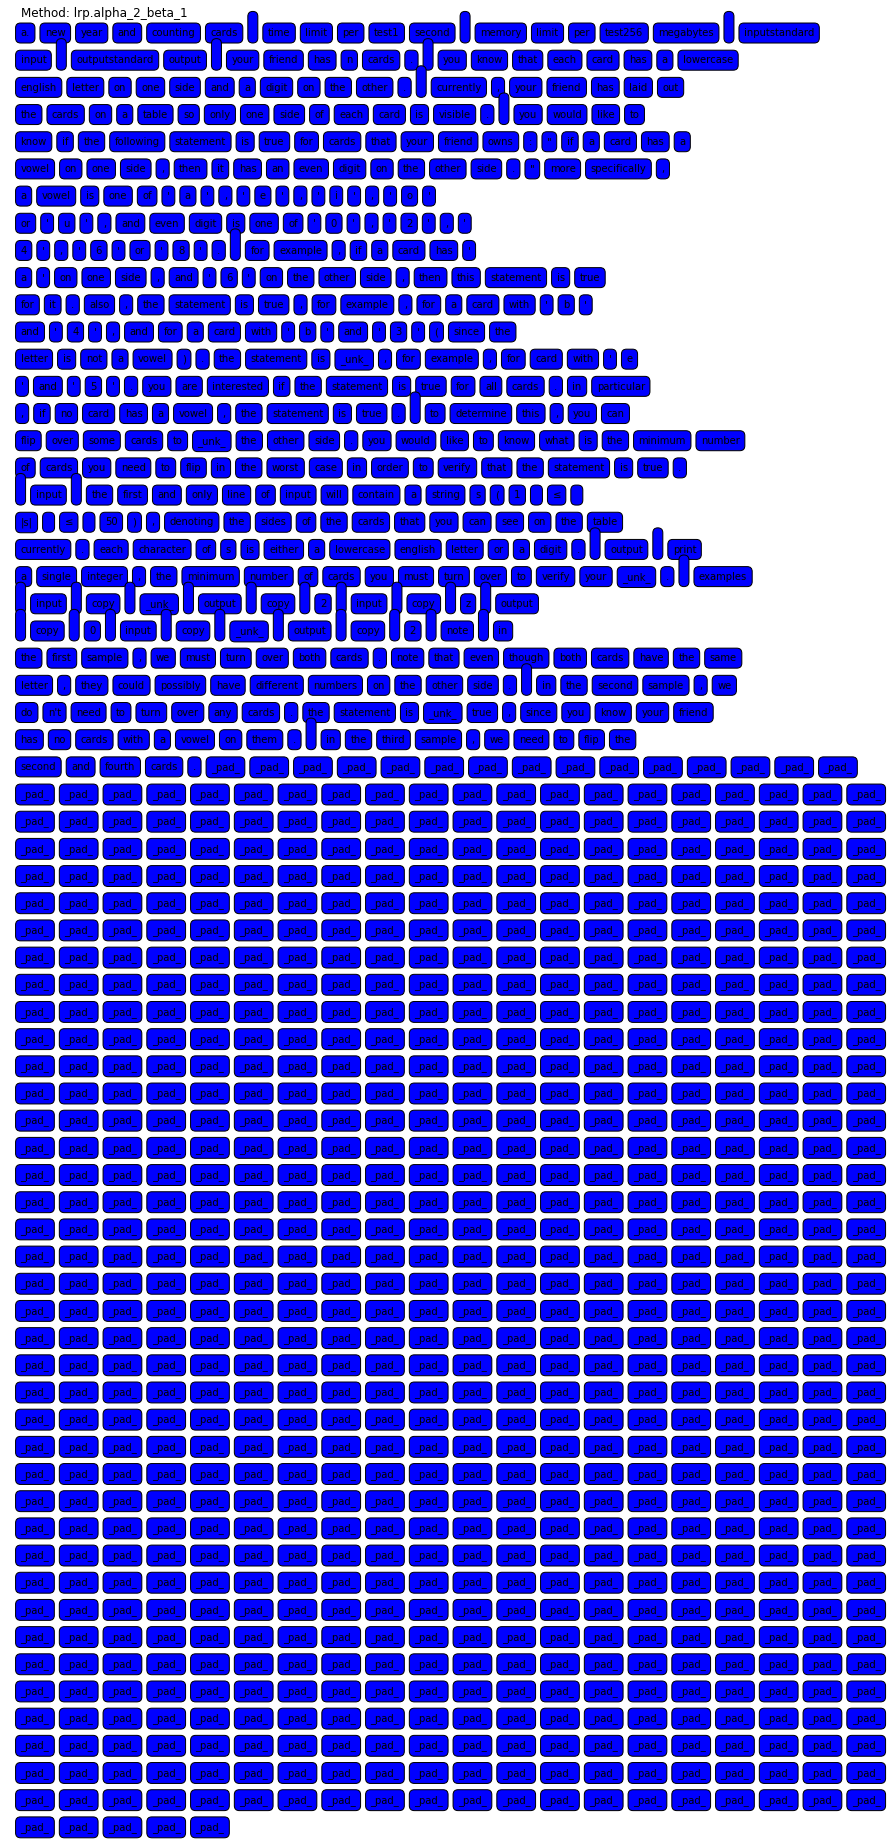

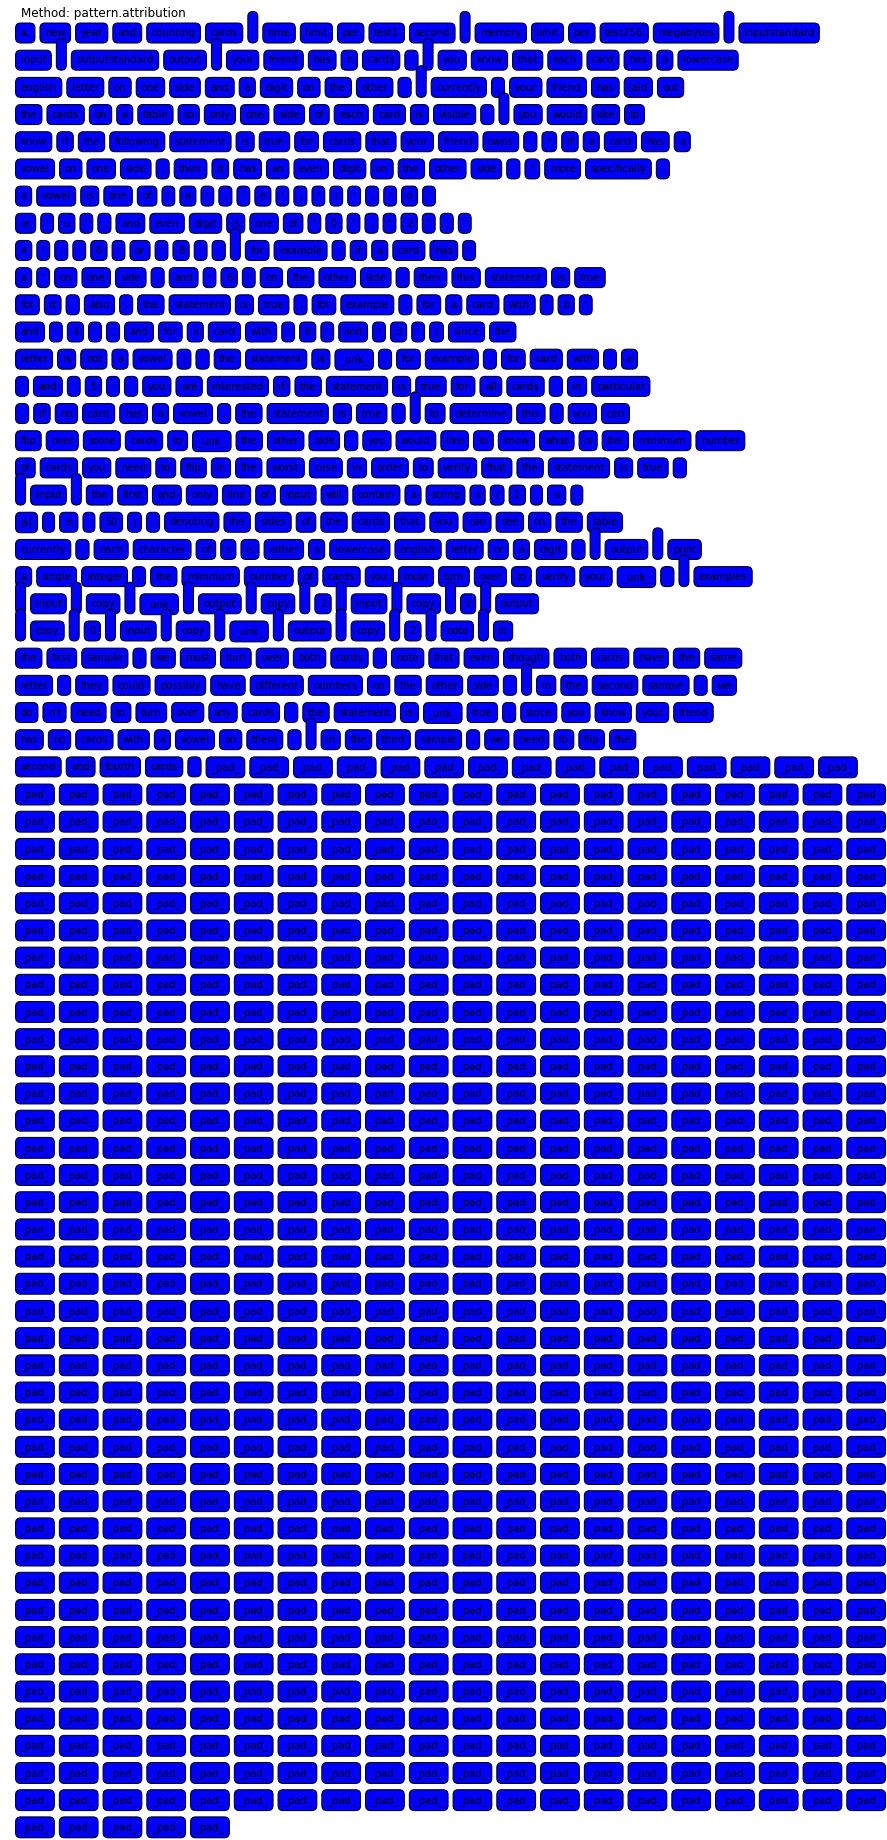

In [27]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):

    words = [decoder[int(t)] for t in Xtest[idx]]
    
#     print('Review(id=%d): %s' % (idx, ' '.join(words)))
    y_true = np.argmax(ytest[idx])
    y_pred = test_sample_preds[i]

#     print("Pred class : %s %s" %
#           (LABEL_IDX_TO_NAME[y_pred], '✓' if y_pred == y_true else '✗')
#          )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()